# Relativistic approximations of the Saha and Planck function in white dwarfs
 relatavstic statmechimcs in white dwarfs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import astropy.constants as c
import astropy.units as u


In [10]:
# T and n in log space 
T = np.logspace(10, 20, 100)
n = np.logspace(20, 30, 100)

A = c.h**3 *c.c**5 / (16*np.pi* c.k_B**3)
A = A.value
B = c.m_p**2 * c.c**4 
B = B.value



In [11]:
mu = np.log(A * n/T )*c.k_B.value*T  + B

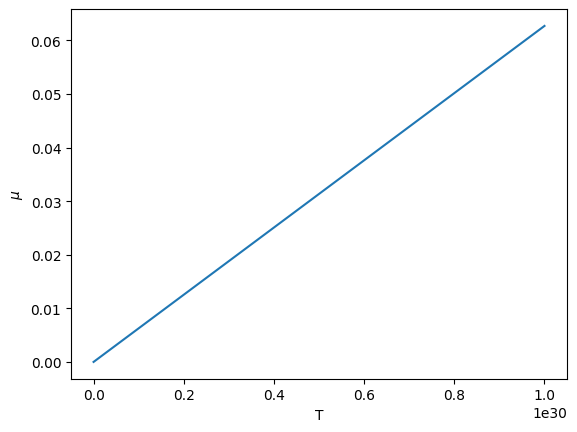

In [12]:
plt.plot(n, mu)

plt.xlabel('T')
plt.ylabel('$\mu$')
plt.show()


In [47]:
# version

n = np.logspace(20, 30, 100)
T = 100000 


A = (c.h**3 *c.c**5 * n) / (16*np.pi* (c.k_B*T)**3)
AA = np.log10(A.value) * c.k_B*T
AA = AA.cgs.value
BB = (c.m_p**2 * c.c**4).value - (c.m_p*c.c**2).value
BB = BB

mu_2 = AA + BB

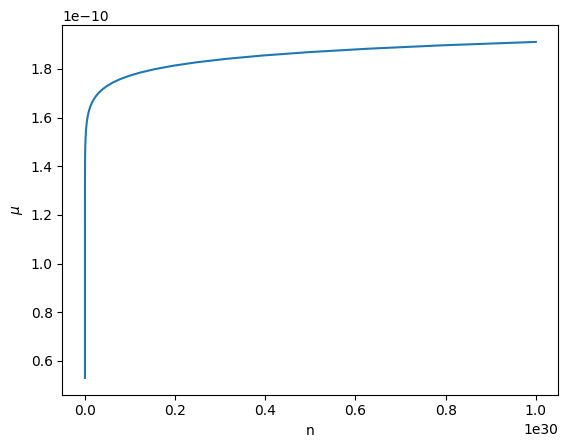

In [48]:
plt.plot(n, mu_2)


plt.xlabel('n')
plt.ylabel('$\mu$')
plt.show()


# <center> $ n = \frac{8 \pi}{h^3} \int_0^\infty \frac{p^2 dp}{e^{ ( -\mu + \sqrt{mc^2 + p^2})/kT} + 1} $

In [40]:
import astropy.constants as c


In [71]:
# solve numerically the equation
# $ n = \frac{8 \pi}{h^3} \int_0^\infty \frac{p^2 dp}{e^{ ( -\mu + \sqrt{mc^2 + p^2})/kT} + 1} $

T = 100000
def integrand(p, mu, T):
    AAA = (mu + np.sqrt(c.m_p.value**2 * c.c.value**4 + p**2))/ (c.k_B.value* T)
    #print(AAA)
    exp = np.exp( AAA )
    #print(exp)
    return p**2 / (exp + 1)

def f(mu, T, n):
    return n - 8*np.pi/(c.h.value**3) * scipy.integrate.quad(integrand, 0, np.inf, args=(mu, T))[0]


mu = scipy.optimize.brentq(f, -1e-10, 1e-10, args=(T, n[34]))

# use f solve to find mu
# mu = scipy.optimize.fsolve(f, 1e-10, args=(T, n[34]))

for i in np.logspace(10, 40, 100):
    #mu = scipy.optimize.fsolve(f, 442, args=(T, i))
    mu = scipy.optimize.brentq(f, 0.01, 1e50, args=(T, i))
    plt.plot(i, mu, 'o')

plt.xlabel('n')
plt.ylabel('$\mu$')

plt.show()


<ipython-input-71-b5a3efc1404b>:8: RuntimeWarning: overflow encountered in exp
  exp = np.exp( AAA )


ValueError: f(a) and f(b) must have different signs

<ipython-input-71-b5a3efc1404b>:8: RuntimeWarning: overflow encountered in exp
  exp = np.exp( AAA )


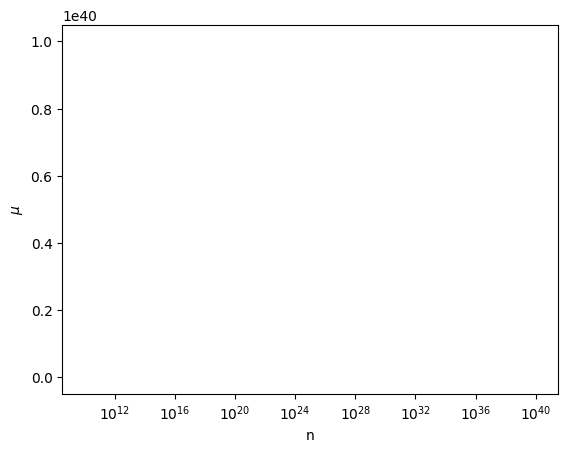

In [80]:
# plot f as a function of n 
# for different T

for i in np.logspace(10, 40, 100):
    plt.plot(i, f(1e10, 1e5, i))

plt.xlabel('n')
plt.ylabel('$\mu$')
plt.xscale('log')
# plt.yscale('log')
plt.show()


In [82]:
8*np.pi/(c.h**3)

<Quantity 8.63916505e+100 1 / (J3 s3)>